In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
from data.dataset import Observation

In [2]:
RANDOM_SEED = 2022
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

num_entries = 50000
X_MIN = -4
X_MAX = 4
NUM_DIMS = 2

In [3]:
import math

#
# def prob_func(x: list[float]) -> np.ndarray:
#     m = max(abs(X_MIN), abs(X_MAX))
#     top = abs(np.sum([(m+1)*(m+1) for dim in x]))
#     p1 = abs(np.sum([(dim+1)*(dim+1) for dim in x]))/top
#     p = [1 - p1, p1]
#     p /= sum(p)
#     return p

def prob_func(x: list[float]) -> np.ndarray:
    m = max(abs(X_MIN), abs(X_MAX))
    dim0 = np.sum([dim if i % 2 == 0 else 0 for i, dim in enumerate(x)])
    dim1 = np.sum([dim if i % 2 == 1 else 0 for i, dim in enumerate(x)])
    if dim0 + dim1 < 2:
        p1 = 0
    # elif 1 <= dim0 + dim1 < 3:
    #     p1 = (dim0 + dim1 - 1) / 3
    else:
        p1 = 1
    p = [1-p1, p1]
    return p

def val_func(x: list[float]) -> np.ndarray:
    # returns array of y values. each y value is a function f(y_i) = (x_1, ..., x_n)
    val = float(np.random.choice([0,1], size=1, p=prob_func(x)))
    return val
    # val = np.array([(dim+1)*(dim+1) for dim in x])
    # return np.mean(val)

def prob_2_func(x: list[float]) -> np.ndarray:
    m = max(abs(X_MIN), abs(X_MAX))
    top = abs(np.sum([(m+1)*(m+1) for dim in x]))
    p1 = abs(np.sum([(dim+1)*(dim+1) for dim in x]))/top
    p = [1-p1, p1]
    p /= sum(p)
    return p

def val_2_func(x: list[float]) -> np.ndarray:
    # returns array of y values. each y value is a function f(y_i) = (x_1, ..., x_n)
    val = float(np.random.choice([0,1], size=1, p=prob_2_func(x)))
    return val
    # val = np.array([(dim+1)*(dim+1) for dim in x])
    # return np.mean(val)



In [4]:
from matplotlib.ticker import FormatStrFormatter

def plot(data_x, data_y = None, cmap = "bwr", fix_minmax = False):
    fig, ax = plt.subplots()
    if data_y is not None:
        if fix_minmax:
            scat = ax.scatter(x=data_x[:,0], y=data_x[:,1], c=data_y[:, 0], cmap=cmap, vmin=0, vmax=1.)
        else:
            scat = ax.scatter(x=data_x[:,0], y=data_x[:,1], c=data_y[:, 0], cmap=cmap)
        fig.colorbar(scat, ax=ax, label='z')
    else:
        scat = ax.scatter(x=data_x[:,0], y=data_x[:,1])
    ax.set_xlabel('a_1')
    ax.set_ylabel('a_2')

def plot_kde(data_x, data_y):
    fig, ax = plt.subplots()
    X, Y = np.mgrid[X_MIN:X_MAX:100j, X_MIN:X_MAX:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    p_weights = [data_y.T, 1-(data_y.T)]
    labels = ["p(Z=1, X)", "p(Z=0, X)"]
    cmaps = ["Reds", "Blues"]
    for weights, label, cmap in zip(p_weights, labels, cmaps):
        kernel = stats.gaussian_kde(data_x.T, weights=weights)
        estimate = np.reshape(kernel(positions).T, X.shape)
        distr = ax.contour(X, Y, estimate, cmap=cmap)
        f = fig.colorbar(distr, ax=ax, label=label)
        f.ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.scatter(x=data_x[:,0], y=data_x[:,1], c=data_y, s=1, cmap="bwr")
    ax.set_xlabel("a_1")
    ax.set_ylabel("a_2")

In [5]:
from scipy import stats
def scatter_hist(data_x, ax,ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)
    ax.scatter(data_x[:, 0], data_x[:,1], s=1)

    bins = np.linspace(X_MIN, X_MAX, abs(X_MAX - X_MIN) * 10 + 1, endpoint=True, dtype=float) - 0.0001
    ax_histx.hist(data_x[:, 0], bins=bins)
    ax_histy.hist(data_x[:, 1], bins=bins, orientation='horizontal')

def plot_hist(data_x: np.array, levels = None):
    fig = plt.figure()
    gs = fig.add_gridspec(2, 3, height_ratios=(3, 12), width_ratios=(12, 3, 1),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)
    ax = fig.add_subplot(gs[1, 0])
    X, Y = np.mgrid[X_MIN:X_MAX:100j, X_MIN:X_MAX:100j]
    positions = np.vstack([X.ravel(), Y.ravel()])
    kernel = stats.gaussian_kde(data_x.T)
    estimate = np.reshape(kernel(positions).T, X.shape)
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)
    scatter_hist(data_x, ax,ax_histx, ax_histy)
    cax = fig.add_subplot(gs[1, 2])
    # distr = ax.imshow(estimate, cmap="gist_heat",
    #           extent=[X_MIN, X_MAX, X_MIN, X_MAX], aspect=ax.get_aspect())
    distr = ax.contour(X, Y, estimate, levels = levels, cmap="Blues")
    fig.colorbar(distr, cax=cax, label='gęstość prawdopodobieństwa')
    ax.set_xlabel('a_1')
    ax.set_ylabel('a_2')
    return distr.levels

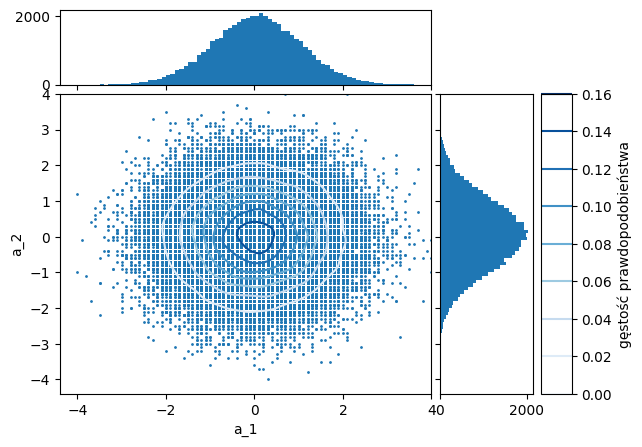

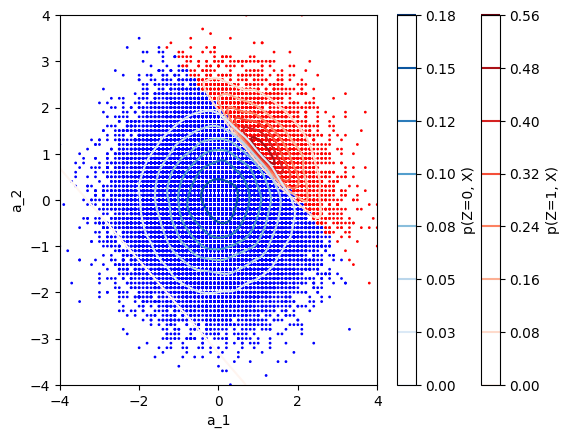

In [6]:
NUM_LABELS = 2
def generate_new_data(num_entries):
    data_x = np.ndarray(shape=(int(num_entries), NUM_DIMS))
    for i in range(NUM_DIMS):
        data_x[:,i] = np.around(np.random.normal(0, 1, num_entries), decimals=1).astype(np.float32)
    data_x = np.where(data_x > X_MAX, np.full(data_x.shape, X_MAX), data_x)
    data_x = np.where(data_x < X_MIN, np.full(data_x.shape, X_MIN), data_x)
    data_y = np.ndarray(shape=(num_entries, NUM_LABELS), dtype=np.float32)
    data_y[:, 0] = [val_func(x) for x in data_x]
    data_y[:, 1] = [val_2_func(x) for x in data_x]
    return data_x, data_y

data_x, data_y = generate_new_data(num_entries)
# plot(data_x=data_x, data_y=data_y, cmap="bwr")
plot_hist(data_x=data_x)
plot_kde(data_x=data_x, data_y=data_y[:,0].reshape(-1))

In [7]:
def aggregate_mean(entries: torch.tensor):
    return entries.mean(axis=0)

def aggregate_by(data_y: torch.tensor, meta: list[Observation], aggregate: callable):
    def get_entries(indices):
        return torch.index_select(data_y, 0, torch.tensor(indices))


    obs_y = torch.stack([aggregate(get_entries(obs.entries_indices)) for obs in meta]).float()
    return obs_y

In [8]:
def generate_independent_observations(data_y: torch.tensor, num_observations: int, aggregate: callable = aggregate_mean) -> list[
    torch.tensor, list[Observation]]:
    # returned data_y is a tensor shaped (entries, values)
    entry_no = len(data_y)
    meta = np.linspace(0, entry_no, entry_no, endpoint=False, dtype=int)
    np.random.shuffle(meta)
    meta = np.array_split(meta, num_observations)
    meta = [Observation(x, i) for i, x in enumerate(meta)]

    obs_y = aggregate_by(data_y, meta, aggregate)
    return [obs_y, meta]

In [9]:
def generate_dependent_observations(data_x: torch.tensor, data_y: torch.tensor, num_observations: int, dims:list[int], aggregate: callable = aggregate_mean) -> list[torch.tensor, list[Observation]]:
    # returned data_y is a tensor shaped (entries, values)
    meta = np.linspace(X_MIN, X_MAX, abs(X_MAX - X_MIN) * 10 + 1, endpoint=True, dtype=float)

    aggregation_masks = [torch.ones(num_entries, dtype=torch.bool)]
    for dim in dims:
        new_aggregation_masks = []
        for mask in aggregation_masks:
            for prev, curr in zip(meta, meta[1:]):
                dim_mask = torch.logical_and((data_x[:, dim] <= curr), (data_x[:, dim] >= prev))
                aggregation_mask = torch.logical_and(dim_mask, mask)
                new_aggregation_masks.append(aggregation_mask)
            aggregation_masks = new_aggregation_masks
    aggregation_indices = [mask.nonzero(as_tuple=True)[0] for mask in aggregation_masks]
    meta = [indices.numpy().tolist() for indices in aggregation_indices if indices.numel() > 0]
    # meta = [torch.logical_and((data_x[:, dims] <= curr), (data_x[:, dims] >= prev)).nonzero(as_tuple=True)[0] for prev, curr in
    #         zip(meta, meta[1:])]
    # meta = [obs.numpy().tolist() for obs in meta if obs.size(dim=0)]
    meta = [Observation(x, i) for i, x in enumerate(meta)]

    obs_y = aggregate_by(data_y, meta, aggregate)

    return [obs_y, meta]

In [10]:
# import itertools
# def get_data_y(data_x, data_y, dims: list[int], dependent:int=True, num_observations=10):
#     data_x = torch.tensor(data_x)
#     data_y = torch.tensor(data_y)
#     if dependent:
#         obs_y, meta = generate_dependent_observations(data_x, data_y, num_observations=num_observations, dims=dims)
#     else:
#         obs_y, meta = generate_independent_observations(data_y, num_observations=num_observations)
#     for obs in meta:
#         for index in obs.entries_indices:
#             data_y[index] = obs_y[obs.value_vec_index]
#     return data_y.numpy()
#
# test_y = np.zeros(np.array(data_y).shape)
# for dim in range(NUM_DIMS):
#     test_y += get_data_y(data_x, data_y, [dim])
# for dim_ab in list(itertools.combinations(range(NUM_DIMS), 2)):
#     test_y += get_data_y(data_x, data_y, list(dim_ab))
# test_y /= 3
# plot(data_x=data_x, data_y=test_y) # what is generated
# plot_kde(data_x=data_x, data_y=test_y[:,0].reshape(-1)) # what is generated

In [11]:
import pandas as pd

labels = ["clicks", "sales"]
allfeatures = ["attr_" + str(i) for i in range(0,NUM_DIMS)]


def aggregate_on_features(features, mincount, data):
    df = data[labels + features]
    df["c"] = 1
    df = df.groupby(features).sum().reset_index()
    df = df[df.c > mincount].copy()
    return df

def aggregate_on_all_pairs(
    allfeatures,
    data,
    mincount=0,
    gaussian_sigma=None,
):
    allpairsdf = pd.DataFrame()
    for f0 in allfeatures:
        feature_1_id = int(f0.split("_")[-1])
        for f1 in allfeatures:
            feature_2_id = int(f1.split("_")[-1])
            if not feature_1_id < feature_2_id:
                continue
            print("aggregating on", f0, f1)
            features = [f0, f1]
            df = aggregate_on_features(features, mincount, data)
            df["feature_1_id"] = feature_1_id
            df["feature_2_id"] = feature_2_id
            df = df.rename(
                {
                    features[0]: "feature_1_value",
                    features[1]: "feature_2_value",
                },
                axis=1,
            )
            allpairsdf = pd.concat([allpairsdf, df])
    if gaussian_sigma is not None:
        allpairsdf["c"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
        allpairsdf["clicks"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
        allpairsdf["sales"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
    return allpairsdf

def aggregate_on_all_single(
    allfeatures, data, mincount=0, gaussian_sigma=None
):
    allpairsdf = pd.DataFrame()
    for f0 in allfeatures:
        print("aggregating on", f0)

        features = [f0]
        df = aggregate_on_features(features, mincount, data)
        df["feature_1_id"] = int(f0.split("_")[-1])
        df = df.rename({features[0]: "feature_1_value"}, axis=1)
        allpairsdf = pd.concat([allpairsdf, df])
    if gaussian_sigma is not None:
        allpairsdf["c"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
        allpairsdf["clicks"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
        allpairsdf["sales"] += np.random.normal(0, gaussian_sigma, len(allpairsdf))
    return allpairsdf

data = pd.DataFrame()
for i, f in enumerate(allfeatures):
    data[f] = np.array(data_x)[:, i]
for i, l in enumerate(labels):
    data[l] = np.array(data_y).reshape((len(data_y), len(labels)))[:, i]
gaussian_sigma = 0
aggregates_single = aggregate_on_all_single(allfeatures, data=data, gaussian_sigma=gaussian_sigma)
aggregates_pairs = aggregate_on_all_pairs(allfeatures, data=data, mincount=0, gaussian_sigma=gaussian_sigma)

aggregating on attr_0
aggregating on attr_1
aggregating on attr_0 attr_1


C:\Users\Zerafoth\AppData\Local\Temp\ipykernel_21924\3195706563.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["c"] = 1


In [12]:
aggregates_single
# aggregates_pairs

,feature_1_value,clicks,sales,c,feature_1_id
0,-4.0,0.0,0.0,2.0,0
1,-3.9,0.0,0.0,1.0,0
2,-3.8,0.0,0.0,1.0,0
3,-3.7,0.0,0.0,2.0,0
4,-3.6,0.0,0.0,4.0,0
...,...,...,...,...,...
73,3.4,4.0,2.0,4.0,1
74,3.5,2.0,2.0,3.0,1
75,3.6,1.0,0.0,1.0,1
76,3.7,1.0,1.0,1.0,1


In [13]:
NORMALIZE = True
FILTER = False
if FILTER:
    aggregates_pairs = aggregates_pairs[(aggregates_pairs.c > 1) & (aggregates_pairs.clicks > 0) & (aggregates_pairs.sales > 0)]
if NORMALIZE:
    aggregates_pairs = aggregates_pairs.assign(zeros = 0)
    aggregates_pairs.c = aggregates_pairs[['clicks', 'sales', 'c', 'zeros']].max(axis=1)
    aggregates_pairs.clicks = aggregates_pairs[['clicks', 'zeros']].max(axis=1)
    aggregates_pairs.sales = aggregates_pairs[['sales', 'zeros']].max(axis=1)
    aggregates_pairs = aggregates_pairs.drop(['zeros'], axis=1)

    aggregates_single = aggregates_single.assign(zeros = 0)
    aggregates_single.c = aggregates_single[['clicks','sales','c','zeros']].max(axis=1)
    aggregates_single.clicks = aggregates_single[['clicks', 'zeros']].max(axis=1)
    aggregates_single.sales = aggregates_single[['sales', 'zeros']].max(axis=1)
    aggregates_single = aggregates_single.drop(['zeros'], axis=1)

aggregates_pairs
# aggregates_single

,feature_1_value,feature_2_value,clicks,sales,c,feature_1_id,feature_2_id
0,-4.0,-1.0,0.0,0.0,1.0,0,1
1,-4.0,1.2,0.0,0.0,1.0,0,1
2,-3.9,-0.1,0.0,0.0,1.0,0,1
3,-3.8,-1.1,0.0,0.0,1.0,0,1
4,-3.7,-1.8,0.0,0.0,1.0,0,1
...,...,...,...,...,...,...,...
3108,3.8,-0.1,1.0,0.0,1.0,0,1
3109,3.9,-0.4,1.0,1.0,1.0,0,1
3110,4.0,-1.0,1.0,0.0,1.0,0,1
3111,4.0,-0.6,1.0,0.0,1.0,0,1


In [14]:
# if NUM_DIMS == 2:
#     fig, ax = plt.subplots()
#     scat = ax.scatter(x=aggregates_pairs["feature_1_value"], y=aggregates_pairs["feature_2_value"], c=aggregates_pairs["clicks"] / aggregates_pairs["c"], cmap="gist_rainbow", vmin=0, vmax=1.)
#     ax.set_xlabel('a_1')
#     ax.set_ylabel('a_2')
#     fig.colorbar(scat, ax=ax, label='z')

In [15]:
import networkx as nx
from statistics import mean
class TestDataGraph(nx.DiGraph):
    def __init__(self):
        super().__init__(self)
        self.no_attributes = NUM_DIMS

    @staticmethod
    def probability(individual_count: int, sum_count: float, mean_count: float, no_objects: int, eps: np.longdouble = np.finfo(np.longdouble).eps):
        return (np.longdouble(individual_count) + eps) / (
                np.longdouble(sum_count) + eps)
        # return (np.longdouble(individual_count) + np.longdouble(mean_count) + eps) / (
        #         np.longdouble(sum_count) + (np.longdouble(no_objects) * np.longdouble(mean_count)) + eps)

    def get_probabilities_for(self, objects, from_objects=None, attr="count", cattr=None):
        if from_objects is None:
            from_objects = objects
        objects_counts = [float(from_objects[obj][attr]) for obj in objects]
        sum_count = sum(objects_counts)
        mean_count = mean(objects_counts)
        if cattr is not None:
            sum_count = sum([float(from_objects[obj][cattr]) for obj in objects])
            mean_count = mean([float(from_objects[obj][cattr]) for obj in objects])
        return np.array(
            [self.probability(individual_count, sum_count, mean_count, len(objects_counts)) for individual_count in
             objects_counts])

    def remove_unreachable_nodes(self):
        to_delete = []
        for node in tqdm(self.nodes(), total=self.number_of_nodes(), desc="Removing unreachable nodes"):
            node_edges = self.edges(node)
            if len(node_edges) == 0:
                to_delete.append(node)
        for node in to_delete:
            self.remove_node(node)
        del to_delete

    def assign_probabilities(self):
        node_probabilities = {}
        edge_probabilities = {}
        nprobs = self.get_probabilities_for(self.nodes(), attr="count")
        for node, prob in tqdm(zip(self.nodes(), nprobs), total=self.number_of_nodes(), desc="Assigning probabilities count"):
            node_probabilities[node] = prob
            edge_probs = self.get_probabilities_for(self.edges(node), self.edges(), attr="count")
            for edge, eprob in zip(self.edges(node), edge_probs):
                edge_probabilities[edge] = eprob
        nx.set_node_attributes(self, node_probabilities, name="ct_prob")
        del node_probabilities
        nx.set_edge_attributes(self, edge_probabilities, name="ct_prob")
        del edge_probabilities
        del nprobs
        node_probabilities = {}
        edge_probabilities = {}
        nprobs = self.get_probabilities_for(self.nodes(), attr="clicks", cattr="count")
        for node, prob in tqdm(zip(self.nodes(), nprobs), total=self.number_of_nodes(), desc="Assigning probabilities clicks"):
            node_probabilities[node] = prob
            edge_probs = self.get_probabilities_for(self.edges(node), self.edges(), attr="clicks", cattr="count")
            for edge, eprob in zip(self.edges(node), edge_probs):
                edge_probabilities[edge] = eprob
        nx.set_node_attributes(self, node_probabilities, name="cl_prob")
        del node_probabilities
        nx.set_edge_attributes(self, edge_probabilities, name="cl_prob")
        del edge_probabilities
        del nprobs

    def create_nodes(self, data_singles):
        for entry in data_singles:
            feature_value, clicks, sales, count, feature_id = entry
            node = f"attr_{int(feature_id)}_val_{feature_value}"
            self.add_node(node, count=float(count), clicks=float(clicks), sales=float(sales))

    def create_edges(self, data_pairs):
        for entry in data_pairs:
            feature_1_value, feature_2_value, clicks, sales, count, feature_1_id, feature_2_id = entry
            node_a = f"attr_{int(feature_1_id)}_val_{feature_1_value}"
            node_b = f"attr_{int(feature_2_id)}_val_{feature_2_value}"
            self.add_edge(node_a, node_b, count=float(count), clicks=float(clicks), sales=float(sales))
            self.add_edge(node_b, node_a, count=float(count), clicks=float(clicks), sales=float(sales))

    def prep(self, data_singles, data_pairs):
        self.create_nodes(data_singles)
        self.create_edges(data_pairs)
        self.remove_unreachable_nodes()
        self.assign_probabilities()
        self.clicks_sum = 0
        self.count_sum = 0
        for node in self.nodes():
            self.clicks_sum += np.float64(self.nodes()[node]["clicks"])
            self.count_sum += np.float64(self.nodes()[node]["count"])
        self.global_z_prob = self.clicks_sum / self.count_sum
        print(self.clicks_sum, self.count_sum, self.global_z_prob)

In [16]:
from typing import Callable
import networkx as nx
import numpy as np
import re
from statistics import mean

class Path:
    def __init__(self, edges=[]):
        self.edges = edges
        self.nodes = [edges[0][0], *[edge[1] for edge in edges]] if len(edges) else []
        self.attributes = [self.attribute(node) for node in self.nodes]

    @staticmethod
    def attribute(node):
        return re.search(r'^attr_(.*)_val_(.*)$', node).group(1)

    def add_edge(self, edge):
        # if edge[0] is not in self.edges - path is incorrect
        if len(self.edges) == 0:
            new_node = edge[0]
            self.attributes.append(self.attribute(new_node))
            self.nodes.append(new_node)
        new_node = edge[1]
        self.attributes.append(self.attribute(new_node))
        self.nodes.append(new_node)
        self.edges.append(edge)


    def __len__(self):
        return len(self.edges)


class DataGenerator:
    def __init__(self, data_graph: nx.Graph, ctr_normalize: Callable, eps: np.float64 = np.finfo(np.float64).eps):
        self.data_graph = data_graph
        self.no_attributes = data_graph.no_attributes
        self.eps = eps
        self.ctr_normalize = ctr_normalize

    @staticmethod
    def values_from_node(node):
        ret = re.search(r'^attr_(.*)_val_(.*)$', node)
        attr = ret.group(1)
        val = ret.group(2)
        return int(attr), float(val)

    @staticmethod
    def get_probabilities_for(objects, from_objects=None, attr="ct_prob"):
        if from_objects is None:
            from_objects = objects
        probs = [from_objects[entry][attr] for entry in objects]
        probs = [prob / sum(probs) for prob in probs]
        return probs

    def get_random_from(self, objects: list[tuple], from_objects=None):
        probs = self.get_probabilities_for(objects, from_objects)
        try:
            chosen_index = np.random.choice(len([obj for obj in objects]), 1, p=probs)[0]
            # len(objects) != len([obj for obj in objects]), apparently some kind of bug in networkx library
            return list(enumerate(objects))[chosen_index][1], chosen_index
        except ValueError:
            return None

    def get_entry_path(self, initial_node):
        path = Path(edges=[])
        probs = []
        edge, prob = self.get_next_edge(from_node=initial_node, path=path)
        if not edge:
            return path
        path.add_edge(edge)
        probs.append(prob)
        while len(path) != self.no_attributes - 1:
            edge, prob = self.get_next_edge(from_node=edge[1], path=path)
            if not edge:
                return path
            path.add_edge(edge)
            probs.append(prob)
        return path, probs

    def get_next_edge(self, from_node, path):
        def not_in_visited(new_node):
            return re.search(r'^attr_(.*)_val_(.*)$', new_node).group(1) not in path.attributes

        def has_edges_with_other_attributes(new_node):
            for node in path.nodes:
                if not self.data_graph.has_edge(new_node, node):
                    return False
            return True

        def is_viable(edge):
            new_node = edge[1]
            return not_in_visited(new_node) #and has_edges_with_other_attributes(new_node)

        viable_neighbor_edges = [edge for edge in self.data_graph.edges(from_node) if is_viable(edge)]
        if len(viable_neighbor_edges) == 0:
            return None

        edge, chosen_index = self.get_random_from(viable_neighbor_edges, self.data_graph.edges())

        clicks = [np.float64(self.data_graph.edges()[edge]["clicks"]) for edge in viable_neighbor_edges]
        counts = [np.float64(self.data_graph.edges()[edge]["count"]) for edge in viable_neighbor_edges]
        cl_prob = clicks[chosen_index] / sum(counts)
        ct_prob = counts[chosen_index] / sum(counts)
        return edge, [cl_prob, ct_prob]

    # Average of probabilities for all edges and nodes
    def expected_z_for(self, obj):
        clicks = float(obj["clicks"])
        sales = float(obj["sales"])
        count = float(obj["count"])
        return [self.ctr_normalize(clicks, count, self.eps), self.ctr_normalize(sales, count, self.eps)]

    def expected_z_for_entry(self, path):
        expected_z_aggregates = [*[self.expected_z_for(self.data_graph.edges()[edge]) for edge in path.edges],
                                 *[self.expected_z_for(self.data_graph.nodes()[node]) for node in path.nodes],
                                 *[self.expected_z_for(self.data_graph.nodes()[node]) for node in path.nodes]]
        return np.array(expected_z_aggregates).mean(axis=0)

    def get_entry_data(self, path):
        data_x = [self.values_from_node(node) for node in path.nodes]
        data_x.sort(key=lambda x: x[0]) # sort by attribute id
        data_x = np.array(data_x)[:, 1]
        expected_z = self.expected_z_for_entry(path)
        return data_x, expected_z


    def generate_entry(self):
        nodes = self.data_graph.nodes()
        entry_path = None
        while entry_path is None or len(entry_path) != self.no_attributes - 1:
            initial_node, chosen_index = self.get_random_from(nodes)
            init_prob = self.data_graph.nodes()[initial_node]["clicks"] / self.data_graph.nodes()[initial_node]["count"]

            entry_path, probs = self.get_entry_path(initial_node)
        expected_z = 1 - init_prob
        # print(cl_init_prob, ct_init_prob)
        for cl_prob, ct_prob in probs:
            expected_z = expected_z * (1 - (cl_prob / ct_prob))
            # print(cl_prob, ct_prob)
        expected_z = 1 - expected_z
        expected_z_1 = np.array([expected_z])
        data_x, expected_z_2 = self.get_entry_data(entry_path)
        return data_x, expected_z_1, expected_z_2

In [17]:
from data.ctr_normalize import CTRNormalize
from tqdm import tqdm

data_graph = TestDataGraph()
data_graph.prep(data_singles=aggregates_single.to_numpy(), data_pairs=aggregates_pairs.to_numpy())
DG = DataGenerator(data_graph=data_graph, ctr_normalize=CTRNormalize.no_action)


Assigning probabilities clicks: 100%|██████████| 159/159 [00:00<00:00, 2606.57it/s]

8194.0 100000.0 0.08194


In [18]:
DG.generate_entry()

(array([-0.2,  0. ]), array([0.01794872]), array([0.01992607, 0.04912332]))

In [19]:
NUM_GENERATED = 50000
data_yp = [[prob_func(x)[1], prob_2_func(x)[1]] for x in data_x]
gen_data_x = []
gen_data_y1 = []
gen_data_y2 = []
for i in tqdm(range(NUM_GENERATED)):
    x, y1, y2 = DG.generate_entry()
    gen_data_x.append([float(entry) for entry in x])
    gen_data_y1.append([float(entry) for entry in y1])
    gen_data_y2.append([float(entry) for entry in y2])

100%|██████████| 50000/50000 [01:44<00:00, 477.30it/s]


In [20]:
# levels = plot_hist(data_x=np.array(gen_data_x))
print(np.cov(np.array(gen_data_x).T))
# plot_hist(data_x=data_x, levels=levels)
print(np.cov(np.array(data_x).T))
# print(np.abs(np.cov(np.array(gen_data_x).T) - np.cov(np.array(data_x).T)))

[[1.00942853 0.00489317]
 [0.00489317 1.00300183]]
[[1.00457656 0.00326589]
 [0.00326589 1.00055155]]


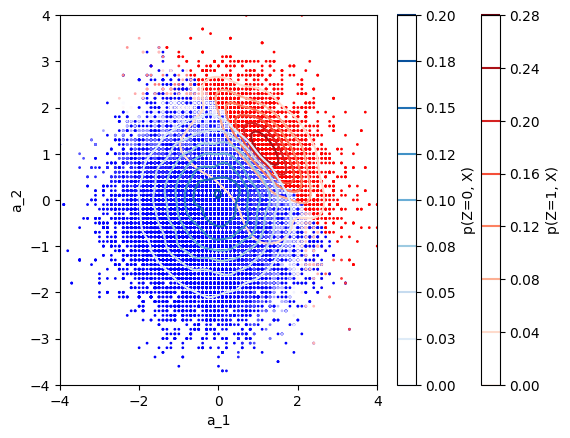

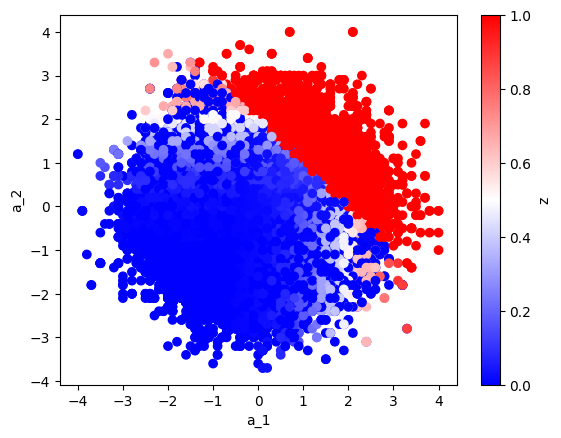

In [21]:
plot_kde(np.array(gen_data_x), data_y=np.array(gen_data_y1).reshape(-1))
plot(np.array(gen_data_x), np.array(gen_data_y1), cmap="bwr")

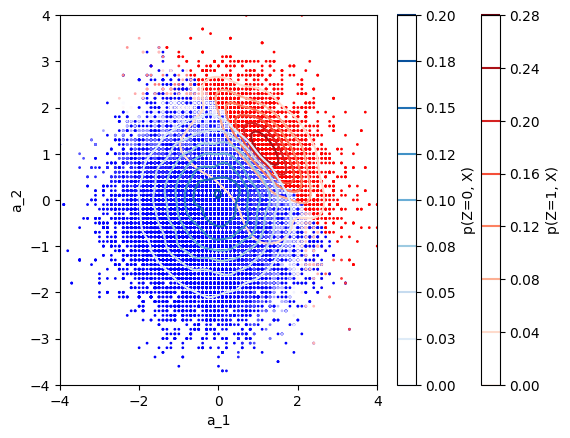

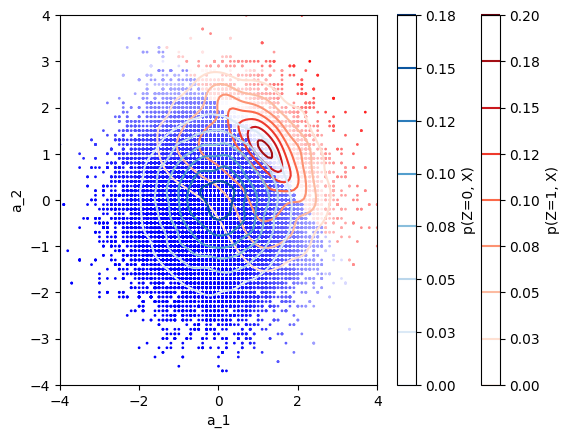

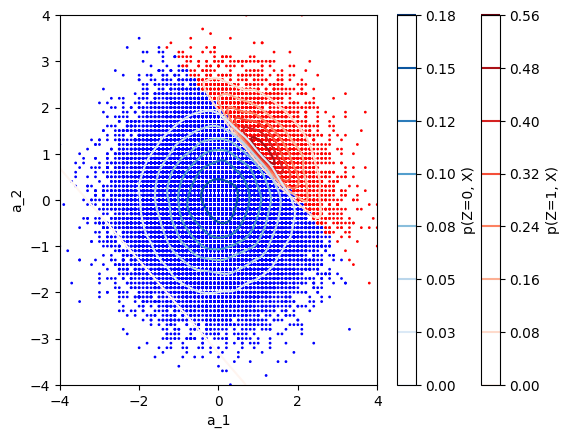

In [22]:
plot_kde(data_x=np.array(gen_data_x), data_y=np.array(gen_data_y1).reshape(-1))
plot_kde(data_x=np.array(gen_data_x), data_y=np.array(gen_data_y2)[:, 0].reshape(-1))
plot_kde(data_x=np.array(data_x), data_y=np.array(data_yp)[:, 0].reshape(-1))

In [ ]:
from scipy import optimize
def aggregate_pow(z: torch.tensor, k):
    return torch.pow(z.mean(axis=0), torch.tensor(k))
    # przeskalowanie z użyciem exponential function tak by proporcja ilości punktow z daną etykietą się zgadzała

def aggregate_mean(z: torch.tensor):
    return z.mean(axis=0)

def aggregate_binary_threshold(z, threshold):
    means = z.mean(axis=0)
    return torch.tensor(list(map(lambda x: 1 if x > torch.tensor(threshold) else 0,means.clone().detach())))
    # 1 -> probability of Z=0 = 100%

def aggregate(z, k):
    return aggregate_pow(z, k)

def get_observations(data_y: torch.tensor, meta: list[Observation], aggregate: Callable, threshold: float):
    def get_entries(indices):
        return torch.index_select(data_y, 0, torch.tensor(indices))

    obs_y = torch.stack([aggregate(get_entries(obs.entries_indices), threshold) for obs in meta]).float()
    return obs_y

def observation_values(obs_y: torch.tensor, observations):
    _data_y = np.ndarray(shape=torch.tensor(gen_data_y1).shape, dtype=np.float32)
    for obs in observations:
        for entry_index in obs.entries_indices:
            _data_y[entry_index] = obs_y[obs.value_vec_index]
    return _data_y

def gen_indep_obs(data_y: torch.tensor, num_observations: int, aggregate: Callable, k = None) -> list[
    torch.tensor, list[Observation]]:
    # returned data_y is a tensor shaped (entries, values)
    entry_no = len(data_y)
    meta = np.linspace(0, entry_no, entry_no, endpoint=False, dtype=int)
    np.random.shuffle(meta)
    meta = np.array_split(meta, num_observations)
    meta = [Observation(x, i) for i, x in enumerate(meta)]
    if k is None:
        def fitness(k):
            obs_y = get_observations(data_y, meta, aggregate, k)
            vals = observation_values(obs_y, meta)
            # return abs(vals.mean(axis=0)[0] - data_graph.global_z_prob)
            return abs(np.count_nonzero(vals > 0.5) - (NUM_GENERATED / 2))
            # return abs(vals.mean(axis=0)[0] - 0.5)
        # could be more optimal, brute force is fast enough for now
        optimal = optimize.brute(fitness, ranges=[slice(0.01,2,0.01)], full_output=True)
        # search for such "k", for which the proportion of "0" to "1" labels is possibly close to initial data
        print(optimal)
        k = optimal[0][0]
    obs_y = get_observations(data_y, meta, aggregate, k)
    # obs_y = get_observations(data_y, meta, aggregate)
    return obs_y, meta, k

NUM_OBSERVATIONS = 5000
gen_obs_y_test, gen_meta_test, k = gen_indep_obs(torch.tensor(gen_data_y1), NUM_OBSERVATIONS, aggregate)

In [ ]:
gen_data_y_vals_fixed = observation_values(gen_obs_y_test, gen_meta_test).reshape(-1)
gen_data_y_vals = np.array(gen_data_y1).reshape(-1)
data_y_vals = np.array(data_y[:,0]).reshape(-1)
gen_data_y_vals_fixed.sort()
gen_data_y_vals.sort()
data_y_vals.sort()
indices = np.arange(len(data_y_vals)) / len(data_y_vals)
fig, ax = plt.subplots()
ax.plot(indices, data_y_vals, label="p(    p(Z =1|X=x)   < t)")
ax.plot(indices, gen_data_y_vals, label="p(    p(Z'=1|X'=x)  < t)")
ax.plot(indices, gen_data_y_vals_fixed, label="p(T'(p(Z'=1|X'=x)) < t)")
ax.set_ylabel('F(t)')
ax.set_xlabel('t')
ax.legend()

In [ ]:
fig, ax = plt.subplots()
for k in np.logspace(-10, 10, 20, base=2):
    obsy, metay, _ = gen_indep_obs(torch.tensor(gen_data_y1), NUM_OBSERVATIONS, aggregate, k)
    vals = observation_values(obsy, metay).reshape(-1)
    indices = np.arange(len(vals)) / len(vals)
    vals.sort()
    ax.plot(indices, vals, label=f"k={np.around(k, 5)}")
ax.set_ylabel('F(t)')
ax.set_xlabel('t')
ax.legend(loc='upper left', prop={'size': 8})

def fitness(k):
    obsy, metay, _ = gen_indep_obs(torch.tensor(gen_data_y1), NUM_OBSERVATIONS, aggregate, k)
    vals = observation_values(obsy, metay).reshape(-1)
    return abs(np.count_nonzero(vals > 0.5) - (NUM_GENERATED / 2))

fig, ax = plt.subplots()
k = np.logspace(-10, 10, 20, base=2)
fits = np.array([fitness(i) for i in k])
ax.plot(k, fits)
ax.set_xscale('log')
ax.set_ylabel('g(k)')
ax.set_xlabel('k')
ax.legend()

In [ ]:
_gen_data_x = np.array(gen_data_x)
_gen_data_y = observation_values(gen_obs_y_test, gen_meta_test)
plot_kde(data_x=_gen_data_x, data_y=_gen_data_y.reshape(-1))

In [ ]:
#prepare test data for all compared cases
from data.dataset import Dataset

test_data_x, test_data_y = generate_new_data(int(num_entries / 5))
test_data_x = torch.tensor(test_data_x, dtype=torch.float32)
test_data_y = torch.tensor(test_data_y)
# we use generation of independent observations as a way to split test data into N observations
# because split between test and validation set is a proportion of observations
test_obs_y, test_meta = generate_independent_observations(test_data_y, NUM_OBSERVATIONS/5)
data_test = Dataset(data_x=test_data_x, data_y=test_data_y,
                    obs_y=test_obs_y, observations=test_meta)

In [ ]:
# Aggregate model with dependent observations and using generator for new independent observations
from models.XBNet.aggregate_model import AggregateModel
from sklearn.model_selection import train_test_split
from tqdm import trange
from torch import optim

NUM_ITERS = 1500
BATCH_SIZE = 6
NUM_OBSERVATIONS = 5000
VALIDATE_EVERY_K_ITERATIONS = 5
LEARNING_RATE = 0.001
WEIGHTS = torch.tensor([1-data_graph.global_z_prob, data_graph.global_z_prob], dtype=torch.float)
def weighted_nll_loss(predictions, observations):
    return torch.nn.functional.nll_loss(torch.log(predictions + torch.finfo(torch.float64).eps), torch.argmax(observations, dim=1), weight=WEIGHTS)

def unweighted_nll_loss(predictions, observations):
    return torch.nn.functional.nll_loss(torch.log(predictions + torch.finfo(torch.float64).eps), torch.argmax(observations, dim=1))
LOSS = weighted_nll_loss

train_data_y = torch.tensor(gen_data_y1)
train_data_x = torch.tensor(gen_data_x)

train_obs_y, train_meta, k = gen_indep_obs(train_data_y, NUM_OBSERVATIONS, aggregate)

def T(z):
    return aggregate(z, k)

train_obs_y = torch.tensor(np.array(list(map(lambda x: [1-x[0], x[0]], train_obs_y)), dtype=np.float64))
train_data_y = torch.tensor(np.array(list(map(lambda x: [1-x[0], x[0]], train_data_y)), dtype=np.float64))
test_data_y = torch.tensor(np.array(list(map(lambda x: [1-x[0], x[0]], test_data_y)), dtype=np.float64))


data_train = Dataset(data_x=train_data_x, data_y=train_data_y,
                     obs_y=train_obs_y, observations=train_meta)

layers_raw = [{'nodes': 32, 'nlin': torch.nn.ReLU(inplace=True), 'norm': False, 'bias': True, 'drop': False},
              {'nodes': 20, 'nlin': torch.nn.ReLU(inplace=True), 'norm': True, 'bias': True, 'drop': False}]

aggregate_model = AggregateModel(
    classification=False, layers_raw=layers_raw, aggregate_by=T)
aggregate_model.get_model_for(data_train)

loss_history_agg = []
aggregate_prediction_history = []

for iterIndex in trange(NUM_ITERS):
    aggregate_loss = aggregate_model.train(dataset=data_train,
                                           optimizer=optim.Adam(
                                               aggregate_model.parameters(), lr=LEARNING_RATE),
                                           loss=LOSS,
                                           batch_size=BATCH_SIZE)
    loss_history_agg.append(
        {'proponowana metoda': aggregate_loss})

    if not iterIndex % VALIDATE_EVERY_K_ITERATIONS:
        with torch.no_grad():
            data_x_v, aggregate_predictions = aggregate_model.test(
                dataset=data_test)
            aggregate_prediction_history.append({"x": data_x_v, "z": aggregate_predictions})


In [ ]:
# Aggregate model with independent observations without use of the method
from data.data_utils import split_data
train_data_x = torch.tensor(data_x, dtype=torch.float32)
train_data_y = torch.tensor(data_y)[:,0].reshape(-1,1) # focus only on clicks

train_obs_y, train_meta, k = gen_indep_obs(train_data_y, NUM_OBSERVATIONS, aggregate)

def T(z):
    return aggregate(z, k)

train_obs_y = torch.tensor(np.array(list(map(lambda x: [1-x[0], x[0]], train_obs_y)), dtype=np.float32))
train_data_y = torch.tensor(np.array(list(map(lambda x: [1-x[0], x[0]], train_data_y)), dtype=np.float32))

data_train = Dataset(data_x=train_data_x, data_y=train_data_y,
                     obs_y=train_obs_y, observations=train_meta)
print(train_data_x.shape, train_data_y.shape, train_obs_y.shape)
aggregate_model_ind_avail = AggregateModel(
    classification=False, layers_raw=layers_raw, aggregate_by=T)
aggregate_model_ind_avail.get_model_for(data_train)

loss_history_ind_avail = []
aggregate_prediction_history_ind_avail = []

for iterIndex in trange(NUM_ITERS):
    aggregate_loss = aggregate_model_ind_avail.train(dataset=data_train,
                                           optimizer=optim.Adam(
                                               aggregate_model_ind_avail.parameters(),
                                               lr=LEARNING_RATE),
                                           loss=LOSS,
                                           batch_size=BATCH_SIZE)
    loss_history_ind_avail.append(
        {'metoda Zhanga (dostępne niezależne obserwacje)': aggregate_loss})

    if not iterIndex % VALIDATE_EVERY_K_ITERATIONS:
        with torch.no_grad():
            data_x_v_ind_avail, aggregate_predictions_ind_avail = aggregate_model_ind_avail.test(
                dataset=data_test)
            aggregate_prediction_history_ind_avail.append({"x": data_x_v_ind_avail, "z":aggregate_predictions_ind_avail})

In [ ]:
# Standard model
from models.XBNet.standard_model import StandardModel

standard_model = StandardModel(
    classification=False, layers_raw=layers_raw)
standard_model.get_model_for(data_train)

loss_history_std = []
standard_prediction_history = []

for iterIndex in trange(NUM_ITERS):
    standard_loss = standard_model.train(dataset=data_train,
                                           optimizer=optim.Adam(
                                               standard_model.parameters(), lr=LEARNING_RATE),
                                           loss=LOSS,
                                           batch_size=BATCH_SIZE)
    loss_history_std.append(
        {'metoda standardowa': standard_loss})

    if not iterIndex % VALIDATE_EVERY_K_ITERATIONS:
        with torch.no_grad():
            data_x_v_std, standard_predictions = standard_model.test(
                dataset=data_test)
            standard_prediction_history.append({"x": data_x_v_std, "z":standard_predictions})

with torch.no_grad():
    data_x_t_std, standard_predictions = standard_model.test(
        dataset=data_test)

In [ ]:
# Aggregate model with dependent observations without use of the method
from data.data_utils import split_data

train_data_x = torch.tensor(data_x, dtype=torch.float32)
train_data_y = torch.tensor(data_y)[:,0].reshape(-1,1) # focus only on clicks

train_obs_y_0, train_meta_0 = generate_dependent_observations(train_data_x, train_data_y, NUM_OBSERVATIONS, [0], aggregate_mean)
train_obs_y_1, train_meta_1 = generate_dependent_observations(train_data_x, train_data_y, NUM_OBSERVATIONS, [1], aggregate_mean)
train_obs_y_01, train_meta_01 = generate_dependent_observations(train_data_x, train_data_y, NUM_OBSERVATIONS, [0,1], aggregate_mean)
train_obs_y = np.concatenate((train_obs_y_0, train_obs_y_1, train_obs_y_01), axis=0)
train_meta = np.concatenate((train_meta_0, train_meta_1, train_meta_01), axis=0)

train_obs_y = torch.tensor(np.array(list(map(lambda x: [1-x[0], x[0]], train_obs_y)), dtype=np.float32))
train_data_y = torch.tensor(np.array(list(map(lambda x: [1-x[0], x[0]], train_data_y)), dtype=np.float32))

data_train = Dataset(data_x=train_data_x, data_y=train_data_y,
                     obs_y=train_obs_y, observations=train_meta)

aggregate_model_ind_navail = AggregateModel(
    classification=False, layers_raw=layers_raw, aggregate_by=aggregate_mean)
aggregate_model_ind_navail.get_model_for(data_train)

loss_history_ind_navail = []
aggregate_prediction_history_ind_navail = []

for iterIndex in trange(NUM_ITERS):
    aggregate_loss = aggregate_model_ind_navail.train(dataset=data_train,
                                           optimizer=optim.Adam(
                                               aggregate_model_ind_navail.parameters(),
                                               lr=LEARNING_RATE),
                                           loss=LOSS,
                                           batch_size=BATCH_SIZE)
    loss_history_ind_navail.append(
        {'metoda Zhanga (naiwne wyk. na zal. obs.)': aggregate_loss})

    if not iterIndex % VALIDATE_EVERY_K_ITERATIONS:
        with torch.no_grad():
            data_x_v_ind_navail, aggregate_predictions_ind_navail = aggregate_model_ind_navail.test(
                dataset=data_test)
            aggregate_prediction_history_ind_navail.append({"x": data_x_v_ind_navail, "z":aggregate_predictions_ind_navail})

In [ ]:
# Plot loss history
import plot_utils
import importlib
importlib.reload(plot_utils)

loss_history = []
for agg, ind_avail, ind_navail, std in zip(loss_history_agg, loss_history_ind_avail, loss_history_ind_navail, loss_history_std):
    loss_history.append(agg | ind_avail | ind_navail | std)
plot_utils.plot_losses(loss_history)

In [ ]:
# from IPython.core.display_functions import clear_output
#
# # Plot prediction history for i'th iteration
# data_source = {
#     "aggregate": aggregate_prediction_history,
#     "aggregate_ind_avail": aggregate_prediction_history_ind_avail,
#     "standard": standard_prediction_history
# }
# # models = data_source.keys()
# # for model in models:
# model="aggregate"
# fig = plt.figure()
# ax = fig.add_subplot()
# # for ITER in range(NUM_ITERS/5)*5:
# for ITER in np.arange(0,NUM_ITERS,100):
#     # print(data_source["standard"]["z"])
#     # print(np.argmax(data_source["standard"]["z"],axis=1))
#     # print(np.where(np.argmax(data_source["standard"]["z"],axis=1) == 0, data_source["standard"]["z"][:,0], data_source["standard"]["z"][:,1]).reshape((-1,1)))
#     # print(np.where(data_source["standard"]["z"], )
#     _data_x = data_source[model][math.floor(ITER/5)]["x"].numpy()
#     _data_y = data_source[model][math.floor(ITER/5)]["z"].numpy()
#     ax.scatter(_data_x[:,0], _data_x[:,1], c=_data_y[:, 0], cmap="bwr", vmin=0., vmax=1.)
#     # ax.scatter(_data_x[:,0], _data_x[:,1], c=np.argmax(_data_y, axis=1).reshape(-1,1), vmin=0., vmax=1.)
#     display(fig)
#     clear_output(wait=True)
#     plt.pause(0.05)

In [ ]:
# Plot test results
plot(data_x=np.array(data_x_v), data_y=np.array(aggregate_predictions)[:, 1].reshape((-1, 1)), fix_minmax=True)
plot(data_x=np.array(data_x_v_ind_avail), data_y=np.array(aggregate_predictions_ind_avail)[:, 1].reshape((-1, 1)), fix_minmax=True)
plot(data_x=np.array(data_x_v_ind_navail), data_y=np.array(aggregate_predictions_ind_navail)[:, 1].reshape((-1, 1)), fix_minmax=True)
plot(data_x=np.array(data_x_v_std), data_y=np.array(standard_predictions)[:, 1].reshape((-1, 1)), fix_minmax=True)

In [ ]:
# CLASSIFICATION MEASURES
from sklearn import metrics
prediction_data = [
    {
        "label": 'proponowana metoda',
        "prediction_history": aggregate_prediction_history,
    },
    {
        "label": 'uczenie Zhanga (dost. obserwacje niezależne)',
        "prediction_history": aggregate_prediction_history_ind_avail,
    },
    {
        "label": 'uczenie Zhanga (naiwne wyk. na zal. obs.)',
        "prediction_history": aggregate_prediction_history_ind_navail,
    },
    {
        "label": 'uczenie standardowe',
        "prediction_history": standard_prediction_history,
    },
]
def plot_auc(models, every):
    fig, ax = plt.subplots(figsize=(6, 6))
    for model in models:
        auc_history = []
        for index, iteration in enumerate(model["prediction_history"]):
            predictions = np.argmax(iteration["z"], axis=1)
            targets = np.array(list(map(lambda x: val_func(x), iteration["x"])))
            auc_history.append([index * every, metrics.roc_auc_score(
                targets.reshape(-1), predictions.reshape(-1))])
        auc_history = np.array(auc_history)
        ax.plot(auc_history[:, 0], auc_history[:, 1], label=model["label"])
    ax.set_xlabel('epoka')
    ax.set_ylabel('AUC')
    ax.legend()
    fig.show()


plot_auc(prediction_data, every=VALIDATE_EVERY_K_ITERATIONS)
# test_prediction_data = [
#     {
#         "label": 'uczenie Zhanga',
#         "prediction_history": [aggregate_predictions],
#     },
# ]
# test_targets = observation_subset_for(data=data_y_, dataset=data_test)
# plot_confusion_matrix(test_prediction_data, test_targets)